In [2]:
# load packages:
library(tidyverse)
library(readxl)
library(repr) # for visualization
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)
# library(rvest)
# install.packages("openxlsx")
# library("openxlsx")
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Title: Predicting energy efficency with regression

Introduction:
The heating load of a building (or any space) is defined as "the amount of heat energy that would need to be added to a space to maintain the temperature in an acceptable range" (Government of Australia, https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range.)
Since a higher heating load correlates to more heat energy being required, a higher heating load also correlates (positively) to an increase in energy cost.
A higher heating load correlates to a higher amount of heat energy required and also thus a higher energy cost (bill?). Further, using more energy is determential to the environment.
~~The cost to heat a building amounts to a significant energy cost and also affects the climate.~~
Various factors such as ~~roof area,~~ surface area, overall height of the building, glazing area (ie. size of windows) ~~as well as their distribution~~ can affect the heating cost.
We aim to study the effects of said factors on heating loads.

Question (that we will try to answer):
~~Can we use the surface area, glazing area, and overall height of rooms to predict the amount of heating energy required to maintain the temperature of the room at an acceptable range?~~

What is the (best?) surface area, glazing area, and overall height of a building that will result in the lowest heating load?

The dataset we are using is the "Energy efficiency Data Set" created by researchers at the University of Oxford (UK). The dataset can be found at https://archive.ics.uci.edu/ml/datasets/Energy+efficiency
It contains eight attributes: Relative Compactness, Surface Area, Wall Area, Roof Area, Overall Height, Orientation, Glazing Area, and Glazing Area Distribution and two outcomes: Heating Load and Cooling Load, though strangely, all of the columns are labelled using X1, X2, etc. instead of an actual descriptive name. The dataset has 768 rows of data. TODO: What else should I put for "describe the dataset"???


Preliminary exploratory data analysis:

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
file_name <- "energy-efficiency.xlsx"
download.file(url, file_name)
energy_data <- read_excel(file_name, skip = 1, col_names = c("Relative.Compactness", "Surface.Area", "Wall.Area", "Roof.Area", "Overall.Height", "Orientation", "Glazing.Area", "Glazing.Area.Distribution", "Heating.Load", "Cooling.Load"))
# energy_data <- as_tibble(read.xlsx(url, colNames = FALSE, startRow = 2))
# colnames(energy_data) <- c("Relative.Compactness", "Surface.Area", "Wall.Area", "Roof.Area", "Overall.Height", "Orientation", "Glazing.Area", "Glazing.Area.Distribution", "Heating.Load", "Cooling.Load")
energy_data
#tidy data (I think it's already tidy)

Relative.Compactness,Surface.Area,Wall.Area,Roof.Area,Overall.Height,Orientation,Glazing.Area,Glazing.Area.Distribution,Heating.Load,Cooling.Load
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.98,514.5,294,110.25,7,2,0,0,15.55,21.33
0.98,514.5,294,110.25,7,3,0,0,15.55,21.33
0.98,514.5,294,110.25,7,4,0,0,15.55,21.33
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.62,808.5,367.5,220.5,3.5,3,0.4,5,16.44,17.11
0.62,808.5,367.5,220.5,3.5,4,0.4,5,16.48,16.61
0.62,808.5,367.5,220.5,3.5,5,0.4,5,16.64,16.03


In [11]:
#table with applicable variables
energy_data_reduced <- energy_data |>
                    select(-Relative.Compactness, -Wall.Area, -Roof.Area, -Cooling.Load)
energy_data_reduced

Surface.Area,Overall.Height,Orientation,Glazing.Area,Glazing.Area.Distribution,Heating.Load
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
514.5,7,2,0,0,15.55
514.5,7,3,0,0,15.55
514.5,7,4,0,0,15.55
⋮,⋮,⋮,⋮,⋮,⋮
808.5,3.5,3,0.4,5,16.44
808.5,3.5,4,0.4,5,16.48
808.5,3.5,5,0.4,5,16.64


In [10]:
energy_data_summary <- energy_data_reduced |>
    summarize(Heating.Load.Mean = mean(Heating.Load))
energy_data_summary

Heating.Load.Mean
<dbl>
22.3072


In [3]:
energy_split <- initial_split(energy_data, prop = 0.75, strata = Heating.Load)
energy_train <- training(energy_split)
energy_test <- testing(energy_split)

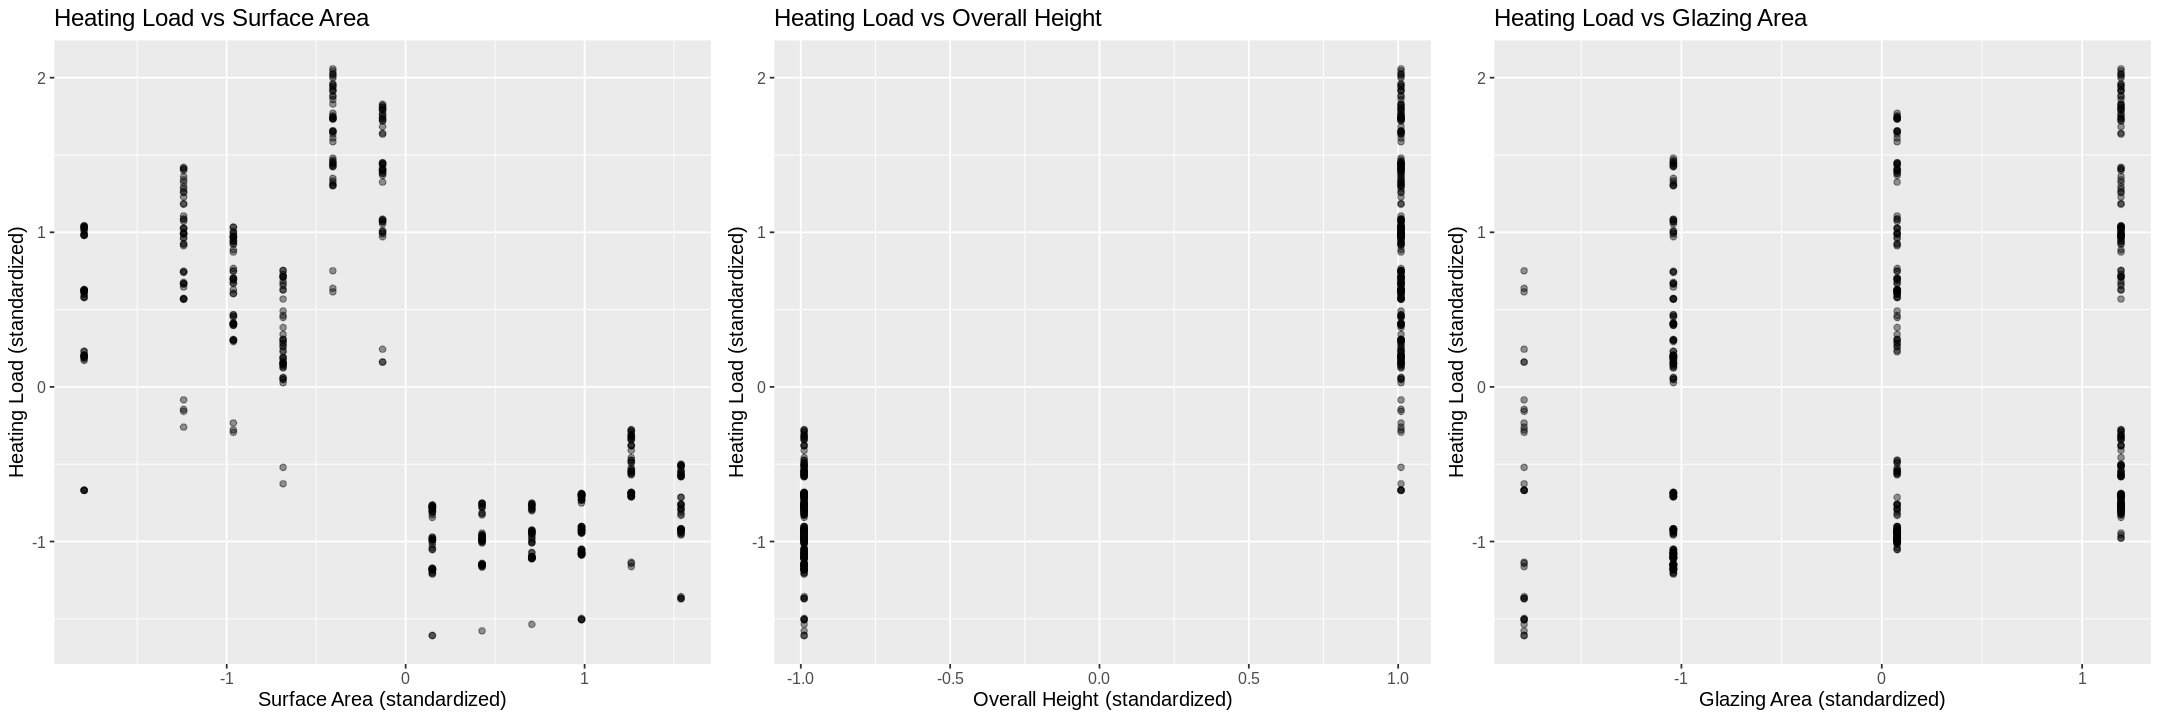

In [4]:
# TODO we need to add tables and explain what these graphs mean

options(repr.plot.width=18, repr.plot.height=6)
energy_train_scale <- energy_train |>
    mutate(scaled_Surface.Area = scale(Surface.Area, center = TRUE),
          scaled_Overall.Height = scale(Overall.Height, center = TRUE),
          scaled_Glazing.Area = scale(Glazing.Area, center = TRUE),
          scaled_Heating.Load = scale(Heating.Load, center = TRUE))
plot_surface <- ggplot(energy_train_scale, aes(x = scaled_Surface.Area, y = scaled_Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Surface Area (standardized)", y = "Heating Load (standardized)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Surface Area")
plot_height <- ggplot(energy_train_scale, aes(x = scaled_Overall.Height, y = scaled_Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Overall Height (standardized)", y = "Heating Load (standardized)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Overall Height")
plot_glazing <- ggplot(energy_train_scale, aes(x = scaled_Glazing.Area, y = scaled_Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Glazing Area (standardized)", y = "Heating Load (standardized)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Glazing Area")
plot_grid(plot_surface, plot_height, plot_glazing, nrow = 1)

Method:

We will first rename the column names to more descriptive names. We will then tidy the data, scale and center it, and wrangle it to find important summary statistics such as the mean and the mode. We will use K-nearest neighbours and linear regression to see which one is more accurate for our data. We will use the variables: Surface Area, Overall Height, and Glazing Area. We decided to use these variables because they are the ones which would affect the heating load most significantly. We did not use Relative Compactness because neither the database nor the associated documentation explain what it really means. We did not use the Roof Area and Wall Area variables because these are encompassed within Surface Area. We did not use Orientation because it’s a categorical variable, and categorical variables can have too much of an impact on our analysis. Further, the values inside of this column are “2”, “3”, “4”, and “5” and the database does not define what those values represent. We also did not use Glazing Area Distribution since it is quite similar to Glazing Area.

Afterwards, we will visualize the results by plotting three histograms, one for each variable that we have picked. We will plot the predictor variables on the x-axis and plot the heating load on the y-axis.

We decided to make the output "heating load" because in Vancouver, you tend to need to keep buildings warm (rather than cool) due to our (somewhat) cold winters.

Expected outcomes and significance.

What do we expect to find? We expect to find that heating load increases (linearaly???) as surface area, overall height, and glazing area increase. ~~, and glazing area distribution increase. However, we do not know how the orientation affects the heating load. ~~

What impact could such findings have?
Our findings could help future architects and city planners determine the optimal building configuration to minimize heating costs and thus reduce energy usage, helping Earth's climate.

What future questions could this lead to?
Would the same configuation also help keep buildings cool?
Are any of these factors affected by the geographic location of the building? (ie. would the same configuration be best for all buildings regardless of their geographic location?)

In [5]:
#print out reached end
reached_end <- "Reached the end of the file."
reached_end

[1] "Reached the end of the file."